**Links**

[Kaggle Dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection?resource=download)

In [1]:
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf



In [2]:
annotations_dir = os.path.abspath("data/annotations/")
images_dir = os.path.abspath("data/images/")

# Parse XML Data Annotations

In [3]:
import xmltodict

def insert_annotation_from_object(annotations, object, data_dict):
    ''' Set information from object and data_dict into annotations'''
    filename = data_dict["annotation"]["filename"]
    width = int(data_dict["annotation"]["size"]["width"])
    height = int(data_dict["annotation"]["size"]["height"])
    depth = int(data_dict["annotation"]["size"]["depth"])
    segmented = int(data_dict["annotation"]["segmented"])
    label = object["name"]
    pose = object["pose"]
    truncated = object["truncated"]
    occluded = object["occluded"]
    difficult = object["difficult"]
    xmin = int(object["bndbox"]["xmin"])
    ymin = int(object["bndbox"]["ymin"])
    xmax = int(object["bndbox"]["xmax"])
    ymax = int(object["bndbox"]["ymax"])

    annotations["filename"].append(filename)
    annotations["width"].append(width)
    annotations["height"].append(height)
    annotations["depth"].append(depth)
    annotations["segmented"].append(segmented)
    annotations["label"].append(label)
    annotations["pose"].append(pose)
    annotations["truncated"].append(truncated)
    annotations["occluded"].append(occluded)
    annotations["difficult"].append(difficult)
    annotations["xmin"].append(xmin)
    annotations["ymin"].append(ymin)
    annotations["xmax"].append(xmax)
    annotations["ymax"].append(ymax)


def get_all_annotations_from_xml(annotations_dir):
    annotations = {
        "filename": [],
        "label": [], 
        "pose": [],
        "truncated": [],
        "occluded": [],
        "difficult": [],
        "xmin": [], 
        "ymin": [], 
        "xmax": [], 
        "ymax": [], 
        "width": [], 
        "height": [],
        "depth": [],
        "segmented": []
    }

    for file in os.listdir(annotations_dir):
        with open(annotations_dir + "/" + file) as xml_file:
            data_dict = xmltodict.parse(xml_file.read())
            xml_file.close()

            object = data_dict["annotation"]["object"]
            # If there is only one instance of a mask in the XML file, the object will return as a dictionary
            if isinstance(object, dict):
                insert_annotation_from_object(annotations, object, data_dict)
                pass

            # If there are multiple instances of a masks in the XML file, the object will return as a list
            elif isinstance(object, list):
                for obj in object:
                    insert_annotation_from_object(annotations, obj, data_dict)


    return pd.DataFrame.from_dict(annotations)

In [4]:
annotations = get_all_annotations_from_xml(annotations_dir)

# EDA

- Histogram of labels
- Sample of 5 images
- Size of cropped images

### Number of images and masks

In [5]:
# Number of pictures
len(annotations["filename"].unique())

853

In [6]:
# Number of masks
len(annotations)

4072

### Histogram of labels

Text(0.5, 1.0, 'Histogram of Labels')

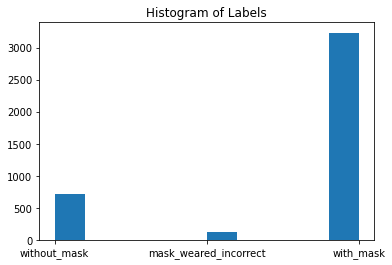

In [7]:
# Histogram of labels
plt.hist(annotations["label"])
plt.title("Histogram of Labels")

### Image Preview 

In [8]:
images = {}

for idx, img_name in enumerate(os.listdir(images_dir)):
    img = load_img(images_dir + "/" + img_name)
    images[img_name] = img

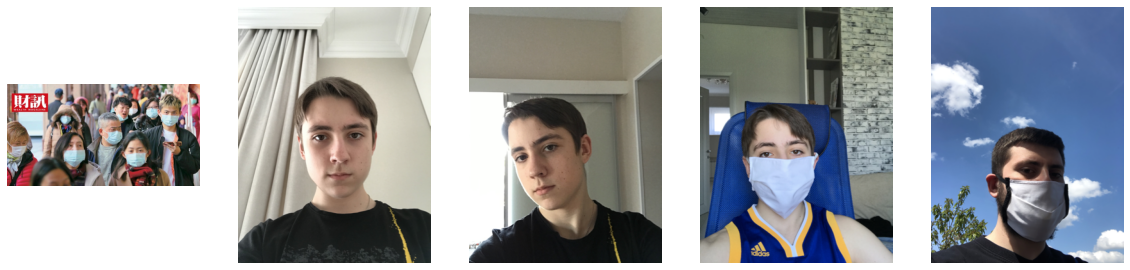

In [9]:
nrows, ncols = 1, 5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
for i in range(ncols):
    axs[i].imshow(list(images.values())[i])
    axs[i].axis('off')

### Scatterplot of cropped image dimensions

In [10]:
annotations["crop_width"] = annotations["xmax"] - annotations["xmin"]
annotations["crop_height"] = annotations["ymax"] - annotations["ymin"]

Text(0.5, 1.0, 'Scatterplot of cropped images dimensions')

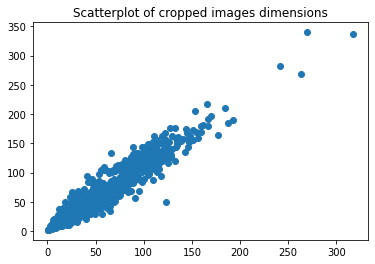

In [11]:
plt.scatter(x=annotations["crop_width"], y=annotations["crop_height"])
plt.title("Scatterplot of cropped images dimensions")

# Feature Engineering

### Remove "mask_weared_incorrect"

Text(0.5, 1.0, 'Histogram of Labels')

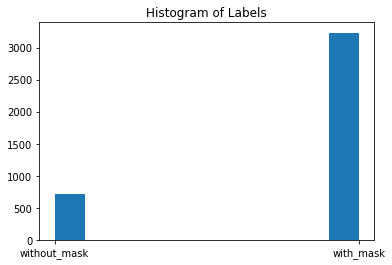

In [12]:
annotations = annotations.drop(annotations[annotations["label"] == "mask_weared_incorrect"].index).reset_index()

plt.hist(annotations["label"])
plt.title("Histogram of Labels")

In [13]:
len(annotations)

3949

### Create normalization column
When the images are being cropped, tensorflow needs the x-y coordinates to be normalized from [0,1] interval

In [14]:
annotations["xmin_normal"] = annotations["xmin"] / annotations["width"]
annotations["xmax_normal"] = annotations["xmax"] / annotations["width"]
annotations["ymin_normal"] = annotations["ymin"] / annotations["height"]
annotations["ymax_normal"] = annotations["ymax"] / annotations["height"]

annotations[["xmin_normal", "xmax_normal", "ymin_normal", "ymax_normal"]]

,xmin_normal,xmax_normal,ymin_normal,ymax_normal
0,0.205980,0.531561,0.485000,0.800000
1,0.142857,0.495017,0.422500,0.770000
2,0.070000,0.107500,0.292135,0.370787
3,0.400000,0.440000,0.247191,0.310861
4,0.435000,0.465000,0.123596,0.194757
...,...,...,...,...
3944,0.677500,0.695000,0.302905,0.340249
3945,0.590000,0.607500,0.377593,0.410788
3946,0.590000,0.607500,0.315353,0.344398
3947,0.660000,0.670000,0.315353,0.340249


# Crop Images

In [20]:
def get_cropped_images(img_filename):
    # Convert image to 4D Tensor shape [1 (number of images), image_height, image_width, depth]
    tf_img = tf.convert_to_tensor([img_to_array(images[img_filename])/256], dtype=tf.float32)

    # Get the rows of img_filename
    masks = annotations[annotations["filename"] == img_filename]

    # Get the bounded boxes
    boxes = tf.constant(masks[["ymin_normal", "xmin_normal", "ymax_normal", "xmax_normal"]], dtype=tf.float32)

    # Set all mask index to 0 since there's only one image
    box_indices = tf.random.uniform(shape=(len(boxes),), minval=0, maxval=len(tf_img), dtype=tf.int32)

    # crop size of image
    crop_size = (100, 100)

    # Crop and resize image
    return tf.image.crop_and_resize(tf_img, boxes, box_indices, crop_size)

img_filename = annotations["filename"][2]
crop_img = get_cropped_images(img_filename)

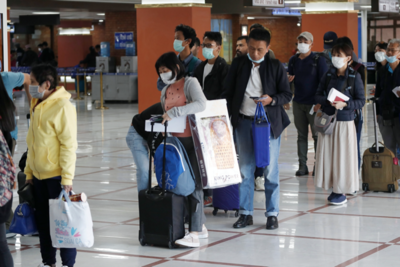

In [23]:
array_to_img(images[img_filename])

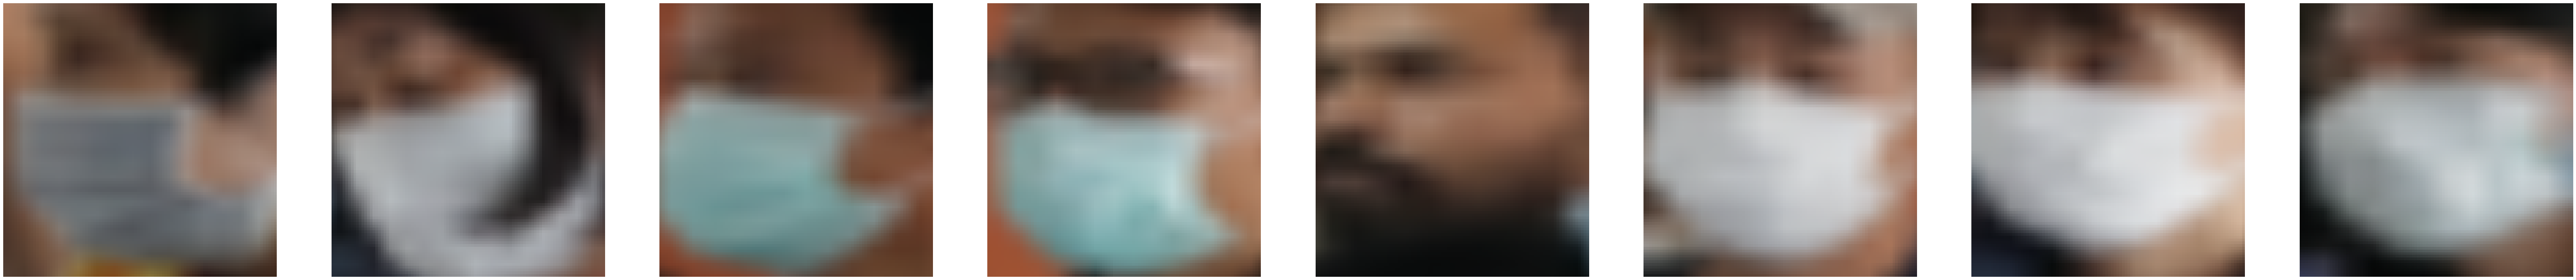

In [25]:
nrows, ncols = 1, len(crop_img)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(100,100))
for i in range(ncols):
    axs[i].imshow(crop_img[i])
    axs[i].axis('off')